In [0]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from pandas_ml import ConfusionMatrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer, f1_score, classification_report

from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from prettytable import PrettyTable
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
from sklearn.datasets import *
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
from sklearn.neighbors import NearestNeighbors

## Utility Functions

In [0]:
#We create a few utility functions whose use is described below


def plot_df_wordcloud(data,labels_list):
    #This function plots the wordcloud for Agglomerative Clustering. These will be called in the following functions.
    print('\n')
    print("Creating a dataframe with Reviews, Cleaned text and Clusters...")
    lst_reviews = list(data['Text'].values) #Saving all reviews into a list
    lst_cleanedtext = list(data['CleanedText'].values) #Saving all Cleaned text into a list
    amz = {'Reviews': lst_reviews,'CleanedText':lst_cleanedtext ,'Clusters': labels_list} #Creating a dictionary with Reviews, Cleaned text and clusters
    df = pd.DataFrame(amz, index=[labels_list], columns=['Reviews','CleanedText', 'Clusters']) #Creating a dataframe of the above dictionary
    print("Dataframe is created!")
    print('\n')
    
    print("The number of reviews in each cluster is:")
    print(df['Clusters'].value_counts()) #Outputs the number of reviews in each cluster
    print('\n')
    print('*'*70)
    
    for i in range(min(labels_list),max(labels_list)+1): #Iterates through K and prints wordcloud and reviews for all the clusters
        print('\n')
        print('\n')
        print("*"*40,'Cluster ',i,"*"*40)
        words=[] #Create an empty list to store words
        for sent in df['CleanedText'][df['Clusters']==i].values: #Splits sentences into words and stores it in a list
            words.append([a for a in sent.split()]) #Appends the split words to above created list
        
        word_list = [item for sublist in words for item in sublist] #Creates a new list of words by flattening the above list since it is a nested list
        print('\n')
        print('Plot of Word Cloud')
        wordcloud1 = WordCloud().generate(" ".join(word_list)) #Initiate wordcloud for the list of words
        plt.figure() #Plots the wordcloud
        plt.imshow(wordcloud1)
        plt.axis("off")
        plt.show()
    
        count = df['Reviews'][df['Clusters']==i].count()    
        if count//2>=9:#Prints random 5 reviews if the number of reviwes in that cluster is more than 100
            print('\n')
            print('\n')
            print('Printing 4 random reviews from cluster',i)
            pd.set_option('display.max_colwidth', -1) #Displays full reviews
            print(df['Reviews'][df['Clusters']==i][count//2:count//2+5])
            print('\n')
            print('\n')
        else: #Prints random reviews if the number of reviwes in that cluster is between 10 and 100
            print('\n')
            print('\n')
            print('Printing random reviews from cluster',i)
            pd.set_option('display.max_colwidth', -1) #Displays reviews in full length
            print(df['Reviews'][df['Clusters']==i][count//2:])
            print('\n')
            print('\n')
            
def agglo_cluster(data,std_data): #Function which implements Agglomerative clustering
    k=list(range(2,11)) #Considers K value between 2 and 10 (inclusive)
    labels_list=[] #Gets the list of labels for each k and stores them into another list 
    silhou_list=[] #Gets the list of silhouette values for each k to plot a bar graph later
    for i in k: #Iterates through the K values
        clf = AgglomerativeClustering(n_clusters=i) #Initialize agglomerative clustering
        clf_labels = clf.fit_predict(std_data) #Gets labels for each data point
        clf_labels_list = clf_labels.tolist() #Convert ndarray into a list
        avg_silhou = silhouette_score(std_data,clf_labels) #Initialize silhouette score
        silhou_list.append(avg_silhou) #Append all the silhoutte scores into the list created above to plot later
        labels_list.append(clf_labels_list) #Append all the lists of labels for each K into another list for use later
        if i == 2 or i == 5 or i == 10: #To check what is happening to clusters at random values of K
            print('\n')
            print('\n')
            print('='*10,'When number of clusters is',i,'='*10)
            print('\n')
            plot_df_wordcloud(data,clf_labels_list) #Creates a dataframe with Reviews, CLeanedText and Clusters and plots wordcloud and prints reviews
            
    
    plt.figure(1) 
    plt.bar(k,silhou_list) #Plots the bar graph
    plt.title('K vs Average Silhouette Score')
    plt.xlabel('K')
    plt.ylabel('Average Silhouette Score')
    plt.show()
    
    for i in range(2,11):
        print("The average Silhouette value of K = {} is {}".format(i,silhou_list[i-2]))
    
    print('\n')
    print('\n')
    max_silhou = max(silhou_list) #Maximum value of silhouette score among all Ks
    k = silhou_list.index(max_silhou)+2 #K value of the corresponding maximum silhouette score
    print('We can observe that K = {} has the highest average silhouette score of {}.'.format(k, max_silhou))
    print('\n')
    print('\n')
    
    if k==2 or k==5 or k==10: #Since these values of k are already plotted we don't plot them again
        print("The wordcloud and reviews for K = {} is already output above.".format(k))
    
    else:
        print('\n')
        print("The wordcloud and reviews for optimal K = {} is plotted as follows.".format(k))
        print('\n')
        plot_df_wordcloud(data,labels_list[k-2]) #Since we already stored the list of labels

# Bag of Words

In [0]:
import pandas as pd
final = pd.read_csv("grouped_data_200.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(3000) #Gets 3000 reviews of positive and 2000 negative scores
neg_2000 = neg.sample(2000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
grouped_data.drop(['Unnamed: 0', 'Unnamed: 0.1','Score'], axis=1, inplace=True)
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (4999, 11)


Observations:
A csv file is imported which consists of 200000 data points. These data points are already sorted on the basis of time. We create a new dataframe with over 5000 data points.

In [0]:
from sklearn.preprocessing import StandardScaler
count_vect = CountVectorizer()
vocab = count_vect.fit_transform(grouped_data['CleanedText'].values.astype('U'))
data = StandardScaler(with_mean=False).fit_transform(vocab)

Observations: Data is vectorized and standardized.

In [0]:
svd = TruncatedSVD(n_components = 1000)
data = svd.fit_transform(data)
print("Percentage of variance retained is {}%".format(svd.explained_variance_ratio_.sum()*100))

Percentage of variance retained is 63.29796058575465%


Observations: Dimensionality reduction is performed and percentage of variance retained is shown.





========== When number of clusters is 2 ==========




Creating a dataframe with Reviews, Cleaned text and Clusters...
Dataframe is created!


The number of reviews in each cluster is:
0    4999
1    1   
Name: Clusters, dtype: int64


**********************************************************************




**************************************** Cluster  0 ****************************************


Plot of Word Cloud


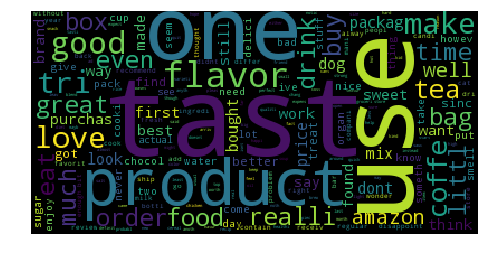





Printing 4 random reviews from cluster 0
0    This mix was given to me originally by someone from Cincinnati. But in the East Coast city where I live, can't find it anywhere. Good mixture of spices, keeps for years, a nice recipe you can make which is a little different but tasty and quick. Always a hit when I make it.                                                                                            
0    This is really quality olive oil for almost the same price if not better than what you'll find in the grocery store.  It has a strong, nutty flavor, reminding us of the freshly pressed oils we've have in Tuscany, Italy.                                                                                                                                                   
0    After having REAL Lichee tea in a California Chinese restaurant, I found that FooJoy Lichee tea is all but flavorless!  I would not recommend it to anyone!                                                   

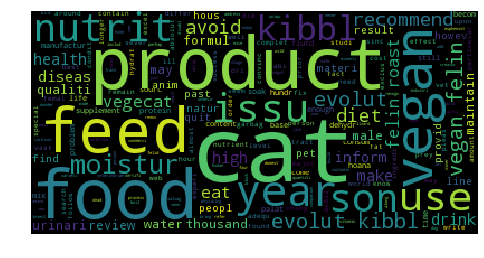





Printing all reviews from cluster 1
1    Unfortunately most people are ill informed about vegan cats, including most veterinarians.<br /><br />Wild cats are in fact obligate carnivores. However, in domesticating the house cat and bringing it into our homes we have effectively removed the cat from its natural prey of mice, insects, birds, lizards, and other small creatures. During the past 100 years or so, as the human food industry was searching for a way to salvage and use all the waste materials from its processing lines, it came upon a wonderful solution. Lets boil it all up and dry it out and add it to the food we make for cats and dogs. As a result, the vast majority of commercial pet foods contain what are euphemistically referred to as the four D's, dead, dying, disabled, and diseased animals, along with other quite undesirable materials. Quite frankly, if you are feeding this junk to your pets, you are effectively poisoning them. We are seeing diseases in pets today that we

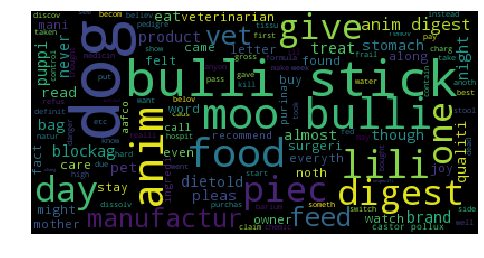





Printing all reviews from cluster 0
0    SADLY, I FOUND OUT THE HARD WAY THAT THESE MOO BULLY STICKS ARE NOT 100% DIGESTIBLE! MY DOG ALMOST DIED AFTER A PIECE DID NOT DISSOLVE IN HER STOMACH.My 3 dogs loved these Moo Bully sticks. I was buying them and giving them because I felt it might causes a chocking danger. I always had plenty of water close by. One day I noticed my dog,Lily, was having very loose stools and that were jelly like in consistency.This same day she stopped eating and began vomiting.I immediately rushed her to my veterinarian.Upon his physical exam he noted that her abdomen was hard and distended.He wanted me to leave her with him so he could do a x-ray. He did and found that she had a bloackege in her stomach!He then started a series of Barium x-rays to watch the blockage to see if it was going to pass. Over a 4 hour period of watching and repeating these barium x-rays it not only showed that the blockage was not passing, but the "item" causing the blockage was s

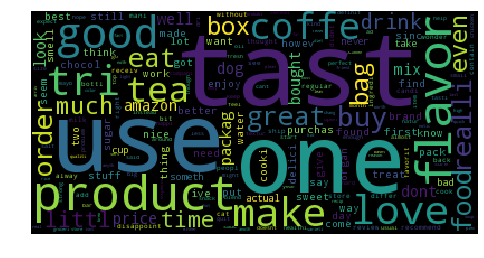





Printing 4 random reviews from cluster 1
1    This is really quality olive oil for almost the same price if not better than what you'll find in the grocery store.  It has a strong, nutty flavor, reminding us of the freshly pressed oils we've have in Tuscany, Italy.                                                                                                                                                   
1    After having REAL Lichee tea in a California Chinese restaurant, I found that FooJoy Lichee tea is all but flavorless!  I would not recommend it to anyone!                                                                                                                                                                                                                   
1    The crisps are simply delicious.  I feel like I am eating something sinful but they are healthier than potato chips or cheese puff snacks.  I was hooked on them and ordered two cases after tasting just one 

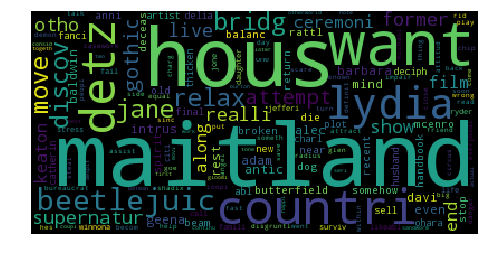





Printing all reviews from cluster 2
2    When Barbara (Geena Davis) and Adam(Alec Baldwin) Maitland move out into the country, they have rest and relaxation on their mind. Not even the well-meaning but intrusive antics of uber-realator Jane Butterfield (Annie McEnroe) can rattle their spirits.<br /><br />...until they discover that they died on an old country bridge near their house after a dog stopped balancing a broken bridge beam. After 'somehow' returning to their house, the Maitlands discover the 'Handbook for the recently deceased' and attempt to decipher it.<br /><br />The plot thickens when the Detzes move in from New York; Jane finally was able to sell their house. Delia (Catherine O'Hara) fancies herself an artist, but husband Charles (Jeffery Jones) just wants to relax in the country after having survived stressful city life. Both he and gothic daughter Lydia (Winnona Ryder) are the most likeable ones in this family.<br /><br />After their own attempts at the supernatura

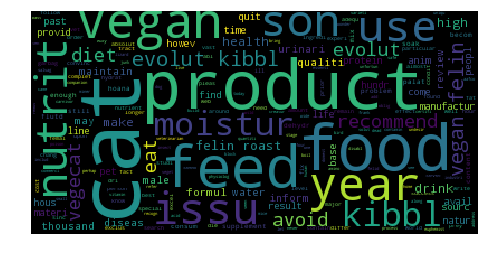





Printing all reviews from cluster 3
3    Unfortunately most people are ill informed about vegan cats, including most veterinarians.<br /><br />Wild cats are in fact obligate carnivores. However, in domesticating the house cat and bringing it into our homes we have effectively removed the cat from its natural prey of mice, insects, birds, lizards, and other small creatures. During the past 100 years or so, as the human food industry was searching for a way to salvage and use all the waste materials from its processing lines, it came upon a wonderful solution. Lets boil it all up and dry it out and add it to the food we make for cats and dogs. As a result, the vast majority of commercial pet foods contain what are euphemistically referred to as the four D's, dead, dying, disabled, and diseased animals, along with other quite undesirable materials. Quite frankly, if you are feeding this junk to your pets, you are effectively poisoning them. We are seeing diseases in pets today that we

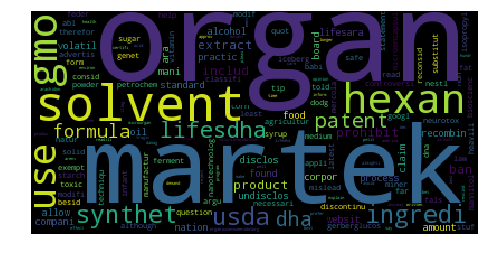





Printing all reviews from cluster 4
4    RECONSIDER THIS FORMULA!!<br /><br />Martek advertises this formula on their website! Nestle owns Gerber now<br /><br />"Although Martek told the board that they would discontinue the use of the controversial neurotoxic solvent n-hexane for DHA/ARA processing, they did not disclose what other synthetic solvents would be substituted. Federal organic standards prohibit the use of all synthetic/petrochemical solvents".<br /><br />Martek Biosciences was able to dodge the ban on hexane-extraction by claiming USDA does not consider omega-3 and omega-6 fats to be "agricultural ingredients." Therefore, they argue, the ban against hexane extraction does not apply. The USDA helped them out by classifying those oils as "necessary vitamins and minerals," which are exempt from the hexane ban. But hexane-extraction is just the tip of the iceberg. Other questionable manufacturing practices and misleading statements by Martek included:<br /><br />Undisclose

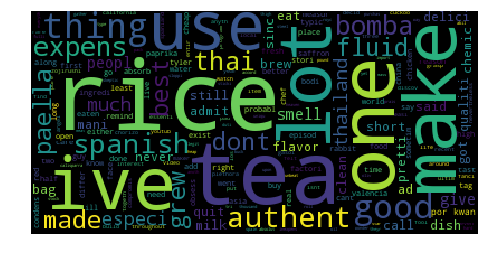





Printing all reviews from cluster 0
0    I've been making and eating rice throughout my entire life of 43 years now.  I've done quite a few fancy ad-hock rice dishes, putting together anything I like in my Zojirushi and Cuckoo rice makers.  Recently, I got interested in making authentic Spanish Paellas.<br /><br />The first thing I discovered was that the ingredients are expensive.  Real Spanish saffron, Spanish Chorizo, and Spanish Paprika are rare and expensive items even in Los Angeles California.  Rabbit isn't easy to find either.  Nevertheless, I went through with the program and decided to build and authentic Paella.  After watching a plethora of YouTube videos, Pau Gasol on local TV, two episodes of Tyler's Ultimate, and one episode of Good Eats, I felt I had a grasp on the essentials.<br /><br />One thing the Spaniards stress: You can fool around with a lot of ingredients, but there are three things you cannot compromise on (1) authentic and pure Saffron, (2) Calisparra Bom

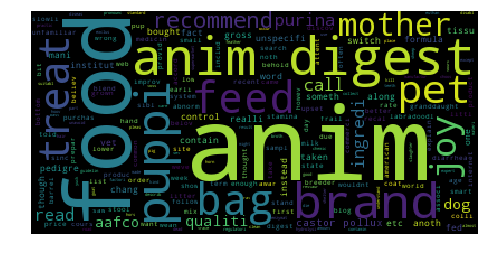





Printing all reviews from cluster 1
1    I recently bought a 7-week-old collie puppy for my granddaughter. Joy, the puppy was taken from her mother at 2 weeks along with 9 siblings because the mother was not producing enough milk. It was the mother's first litter. The pups were hand fed a formula and were a bit small and frail for their ages though their price was not. At any rate the breeder had them on Pedigree puppy food when we purchased her and though their is nothing wrong with the brand I wanted something better for her due to her early weaning. Our 2-year-old Labradoodle is fed "Castor & Pollux" which really improved her coat and stamina etc. when we switched from another brand so I bought Puppy food in the same brand. However our Vet told us that she was unfamiliar with the brand, and that she wouldn't feed it to her. Instead she recommended "Purina One Smart Blend Puppy Formula". I of course ordered a bag and stated mixing it with the Pedigree to switch Joy over slowly so

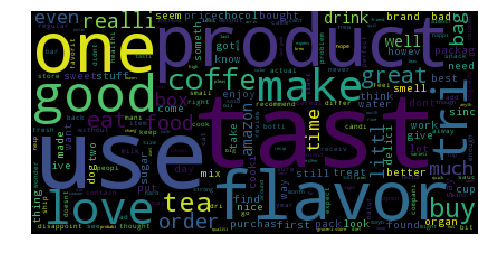





Printing 4 random reviews from cluster 2
2    This is really quality olive oil for almost the same price if not better than what you'll find in the grocery store.  It has a strong, nutty flavor, reminding us of the freshly pressed oils we've have in Tuscany, Italy.                                                                                                                                                   
2    After having REAL Lichee tea in a California Chinese restaurant, I found that FooJoy Lichee tea is all but flavorless!  I would not recommend it to anyone!                                                                                                                                                                                                                   
2    The crisps are simply delicious.  I feel like I am eating something sinful but they are healthier than potato chips or cheese puff snacks.  I was hooked on them and ordered two cases after tasting just one 

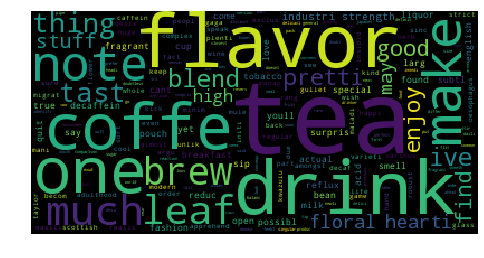





Printing all reviews from cluster 3
3    I've come back to tea after drinking coffee almost exclusively since before adulthood.  A huge part of the migration was, initially, due to that malady of modern life, acid reflux.  Caffeine makes me gullet go gaga.  In fact, I'm even reduced to drinking a blend of decaf and regular tea in order to keep the oesophagus happy.<br />A really cool thing about tea is that, unlike coffee, in its varieties there is a complexity of subtle (and not so subtle) flavors that one can easily apprehend.<br />Sure, there are people who will argue there is a whole range of flavor notes that can be found amongst the various coffee beans and while this is, strictly speaking, true, it is also pretty much true that one cup of good coffee smells and tastes pretty much the same as any other cup of good coffee.  Coffee is not the sort of thing one sips to enjoy as one would a glass of wine.  Drinking tea, on the other hand, can very much become a sipping game possi

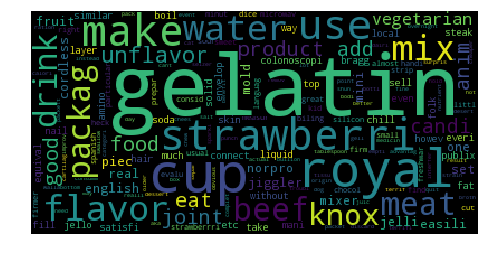





Printing all reviews from cluster 4
4    Royal "Bilingal" Strawberry Gelatin is the same product as Royal ("English Language") Strawberry Gelatin, but in English/Spanish packaging.<br /><br />EVALUATION<br />Good strawberry flavor.  Mixes easily, makes 4 cups.  I like gelatin a little firmer, so I use only 3 cups of water, which I microwave for 5 minutes in a 4-cup measuring cup and then mix-in the Royal Gelatin.  I find a mini-mixer very handy for mixing the gelatin <a href="http://www.amazon.com/gp/product/B000E39LYO">Norpro Cordless Mini Mixer, 5 Piece Set</a><br /><br />ADD FRUIT<br />The strawberrry gelatin is particularly great with real (diced) strawberries which are usually too sour.  The gelatin adds just the right sweetness.<br /><br />JIGGLERS<br />You can make very firm "jigglers" for kids by using only 2 cups of water, or almost "Gummi-Bear" candies by using only 1 one cup of water.  Consider using candy molds  <a href="http://www.amazon.com/gp/product/B003VPW0V8">Fres

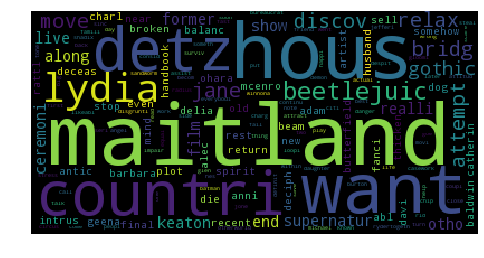





Printing all reviews from cluster 5
5    When Barbara (Geena Davis) and Adam(Alec Baldwin) Maitland move out into the country, they have rest and relaxation on their mind. Not even the well-meaning but intrusive antics of uber-realator Jane Butterfield (Annie McEnroe) can rattle their spirits.<br /><br />...until they discover that they died on an old country bridge near their house after a dog stopped balancing a broken bridge beam. After 'somehow' returning to their house, the Maitlands discover the 'Handbook for the recently deceased' and attempt to decipher it.<br /><br />The plot thickens when the Detzes move in from New York; Jane finally was able to sell their house. Delia (Catherine O'Hara) fancies herself an artist, but husband Charles (Jeffery Jones) just wants to relax in the country after having survived stressful city life. Both he and gothic daughter Lydia (Winnona Ryder) are the most likeable ones in this family.<br /><br />After their own attempts at the supernatura

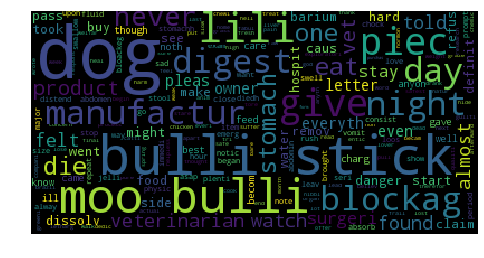





Printing all reviews from cluster 6
6    SADLY, I FOUND OUT THE HARD WAY THAT THESE MOO BULLY STICKS ARE NOT 100% DIGESTIBLE! MY DOG ALMOST DIED AFTER A PIECE DID NOT DISSOLVE IN HER STOMACH.My 3 dogs loved these Moo Bully sticks. I was buying them and giving them because I felt it might causes a chocking danger. I always had plenty of water close by. One day I noticed my dog,Lily, was having very loose stools and that were jelly like in consistency.This same day she stopped eating and began vomiting.I immediately rushed her to my veterinarian.Upon his physical exam he noted that her abdomen was hard and distended.He wanted me to leave her with him so he could do a x-ray. He did and found that she had a bloackege in her stomach!He then started a series of Barium x-rays to watch the blockage to see if it was going to pass. Over a 4 hour period of watching and repeating these barium x-rays it not only showed that the blockage was not passing, but the "item" causing the blockage was s

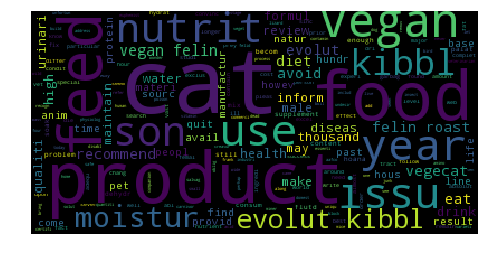





Printing all reviews from cluster 7
7    Unfortunately most people are ill informed about vegan cats, including most veterinarians.<br /><br />Wild cats are in fact obligate carnivores. However, in domesticating the house cat and bringing it into our homes we have effectively removed the cat from its natural prey of mice, insects, birds, lizards, and other small creatures. During the past 100 years or so, as the human food industry was searching for a way to salvage and use all the waste materials from its processing lines, it came upon a wonderful solution. Lets boil it all up and dry it out and add it to the food we make for cats and dogs. As a result, the vast majority of commercial pet foods contain what are euphemistically referred to as the four D's, dead, dying, disabled, and diseased animals, along with other quite undesirable materials. Quite frankly, if you are feeding this junk to your pets, you are effectively poisoning them. We are seeing diseases in pets today that we

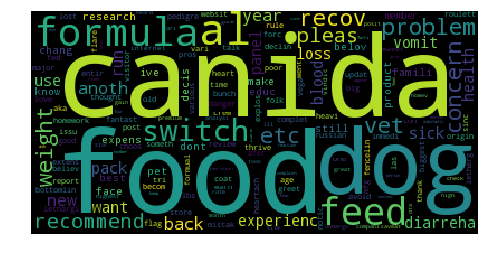





Printing all reviews from cluster 8
8    I fed Canidae ALS (old formula) for 7+ years and my dogs thrived.  Canidae switched their formula (and mfg) and I immediately switched to another food afer the reported of problems.  My feed store talked me into trying their 'new' formula, and I went back to ALS - BIG mistake.  I have experienced 15-20+% weight loss, explosive diarreha, vomitting, lethargy. etc.  I have 5 dogs - 60-100+ lbs, varying pedigrees, ages 1 to 12+ - all sick (15-20% weight loss, poor coats, vomitting, etc.).  I have had to run complete extensive blood panels to rule out other health problems on all the dogs - bottomline - blood panels were OK, food (Canidae) was the issue.  What use to be a fantastic food is now a very dangerous food to feed.  An entire pack of dogs' health declined on the 'new' formula.  I switched foods (something other than Canidae) and my dogs are now recovering.  If you love Las Vegas and Russian Roulette feed Canidae - if want to avoid major 

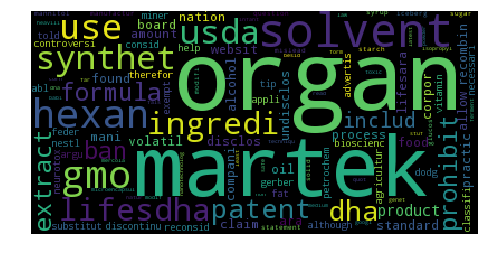





Printing all reviews from cluster 9
9    RECONSIDER THIS FORMULA!!<br /><br />Martek advertises this formula on their website! Nestle owns Gerber now<br /><br />"Although Martek told the board that they would discontinue the use of the controversial neurotoxic solvent n-hexane for DHA/ARA processing, they did not disclose what other synthetic solvents would be substituted. Federal organic standards prohibit the use of all synthetic/petrochemical solvents".<br /><br />Martek Biosciences was able to dodge the ban on hexane-extraction by claiming USDA does not consider omega-3 and omega-6 fats to be "agricultural ingredients." Therefore, they argue, the ban against hexane extraction does not apply. The USDA helped them out by classifying those oils as "necessary vitamins and minerals," which are exempt from the hexane ban. But hexane-extraction is just the tip of the iceberg. Other questionable manufacturing practices and misleading statements by Martek included:<br /><br />Undisclose

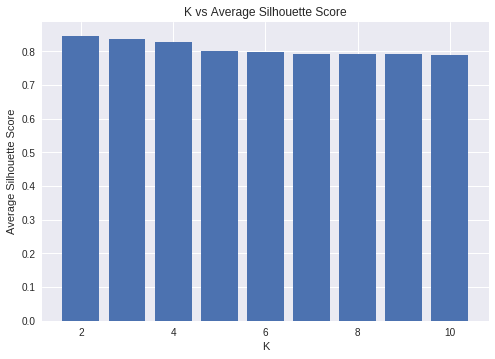

The average Silhouette value of K = 2 is 0.8451231662497245
The average Silhouette value of K = 3 is 0.8374437248886673
The average Silhouette value of K = 4 is 0.827708141243027
The average Silhouette value of K = 5 is 0.8001011969020327
The average Silhouette value of K = 6 is 0.7984935466454305
The average Silhouette value of K = 7 is 0.7923175440028498
The average Silhouette value of K = 8 is 0.7917119022680652
The average Silhouette value of K = 9 is 0.7908962934132582
The average Silhouette value of K = 10 is 0.7903202540892388




We can observe that K = 2 has the highest average silhouette score of 0.8451231662497245.




The wordcloud and reviews for K = 2 is already output above.


In [0]:
agglo_cluster(grouped_data,data)

**Observations: **

**1.** Wordcloud and reviews are printed for k values of 2, 5, 10 to get a sense of what's going on with the data.

**2.** Silhouette scores are plotted for each values of k ranging from 2 to 10. It is observed that k=2 has the highest average silhouette score, hence we declare that k=2 is the best suited number of clusters.

**3.** When k=2, cluster 0 has 4999 elements compared to 1 in cluster 1.

**4.** Cluster 0 reviews mostly revolve the word 'tast', 'use', 'one', 'product'.

**5.** Cluster 1 reviews mostly revolve around the word 'product' and 'cat' which gives us the sense that it is about cat food.

**6.** This featurization produced almost similar results to that of Bag of Words.

# TFIDF

In [0]:
import pandas as pd
final = pd.read_csv("grouped_data_200.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(3000) #Gets 3000 reviews of positive and 2000 negative scores
neg_2000 = neg.sample(2000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
grouped_data.drop(['Unnamed: 0', 'Unnamed: 0.1','Score'], axis=1, inplace=True)
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (5000, 11)


Observations:
A csv file is imported which consists of 200000 data points. These data points are already sorted on the basis of time. We create a new dataframe with over 5000 data points.

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab_tf_idf = tf_idf_vect.fit_transform(grouped_data['CleanedText'].values.astype('U')) #Converts to a sparse matrix of TF-IDF vectors.

Observations:
TFIDF vectorizations of the data is obtained.

In [0]:
data = StandardScaler(with_mean=False).fit_transform(vocab_tf_idf)

Observations:
Data is standardized.

In [0]:
svd = TruncatedSVD(n_components = 1000)
data = svd.fit_transform(data)
print(svd.explained_variance_ratio_.sum())

0.47832529882040753


Observations: Dimensionality reduction is performed and percentage of variance retained is shown.





========== When number of clusters is 2 ==========




Creating a dataframe with Reviews, Cleaned text and Clusters...
Dataframe is created!


The number of reviews in each cluster is:
0    4999
1    1   
Name: Clusters, dtype: int64


**********************************************************************




**************************************** Cluster  0 ****************************************


Plot of Word Cloud


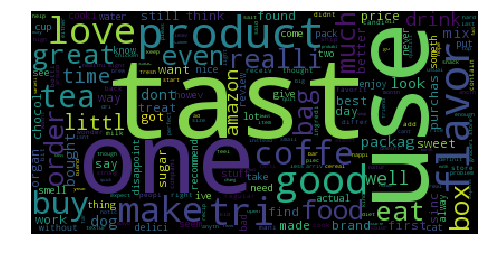





Printing 4 random reviews from cluster 0
0    This mix was given to me originally by someone from Cincinnati. But in the East Coast city where I live, can't find it anywhere. Good mixture of spices, keeps for years, a nice recipe you can make which is a little different but tasty and quick. Always a hit when I make it.                                                                                            
0    This is really quality olive oil for almost the same price if not better than what you'll find in the grocery store.  It has a strong, nutty flavor, reminding us of the freshly pressed oils we've have in Tuscany, Italy.                                                                                                                                                   
0    After having REAL Lichee tea in a California Chinese restaurant, I found that FooJoy Lichee tea is all but flavorless!  I would not recommend it to anyone!                                                   

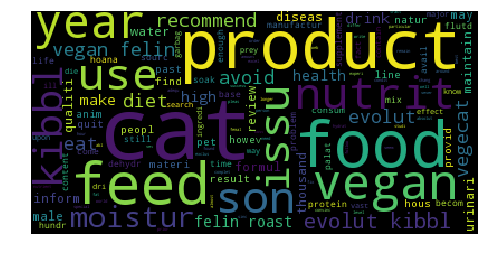





Printing all reviews from cluster 1
1    Unfortunately most people are ill informed about vegan cats, including most veterinarians.<br /><br />Wild cats are in fact obligate carnivores. However, in domesticating the house cat and bringing it into our homes we have effectively removed the cat from its natural prey of mice, insects, birds, lizards, and other small creatures. During the past 100 years or so, as the human food industry was searching for a way to salvage and use all the waste materials from its processing lines, it came upon a wonderful solution. Lets boil it all up and dry it out and add it to the food we make for cats and dogs. As a result, the vast majority of commercial pet foods contain what are euphemistically referred to as the four D's, dead, dying, disabled, and diseased animals, along with other quite undesirable materials. Quite frankly, if you are feeding this junk to your pets, you are effectively poisoning them. We are seeing diseases in pets today that we

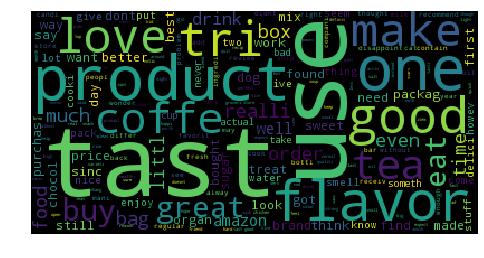





Printing 4 random reviews from cluster 0
0    This mix was given to me originally by someone from Cincinnati. But in the East Coast city where I live, can't find it anywhere. Good mixture of spices, keeps for years, a nice recipe you can make which is a little different but tasty and quick. Always a hit when I make it.                                                                                            
0    This is really quality olive oil for almost the same price if not better than what you'll find in the grocery store.  It has a strong, nutty flavor, reminding us of the freshly pressed oils we've have in Tuscany, Italy.                                                                                                                                                   
0    After having REAL Lichee tea in a California Chinese restaurant, I found that FooJoy Lichee tea is all but flavorless!  I would not recommend it to anyone!                                                   

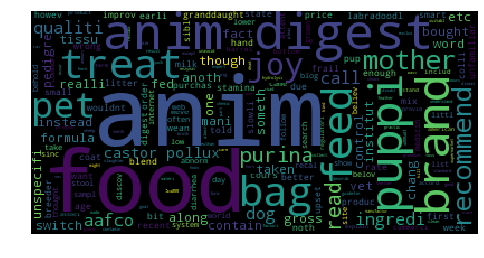





Printing all reviews from cluster 1
1    I recently bought a 7-week-old collie puppy for my granddaughter. Joy, the puppy was taken from her mother at 2 weeks along with 9 siblings because the mother was not producing enough milk. It was the mother's first litter. The pups were hand fed a formula and were a bit small and frail for their ages though their price was not. At any rate the breeder had them on Pedigree puppy food when we purchased her and though their is nothing wrong with the brand I wanted something better for her due to her early weaning. Our 2-year-old Labradoodle is fed "Castor & Pollux" which really improved her coat and stamina etc. when we switched from another brand so I bought Puppy food in the same brand. However our Vet told us that she was unfamiliar with the brand, and that she wouldn't feed it to her. Instead she recommended "Purina One Smart Blend Puppy Formula". I of course ordered a bag and stated mixing it with the Pedigree to switch Joy over slowly so

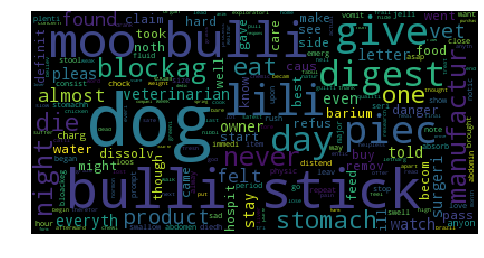





Printing all reviews from cluster 2
2    SADLY, I FOUND OUT THE HARD WAY THAT THESE MOO BULLY STICKS ARE NOT 100% DIGESTIBLE! MY DOG ALMOST DIED AFTER A PIECE DID NOT DISSOLVE IN HER STOMACH.My 3 dogs loved these Moo Bully sticks. I was buying them and giving them because I felt it might causes a chocking danger. I always had plenty of water close by. One day I noticed my dog,Lily, was having very loose stools and that were jelly like in consistency.This same day she stopped eating and began vomiting.I immediately rushed her to my veterinarian.Upon his physical exam he noted that her abdomen was hard and distended.He wanted me to leave her with him so he could do a x-ray. He did and found that she had a bloackege in her stomach!He then started a series of Barium x-rays to watch the blockage to see if it was going to pass. Over a 4 hour period of watching and repeating these barium x-rays it not only showed that the blockage was not passing, but the "item" causing the blockage was s

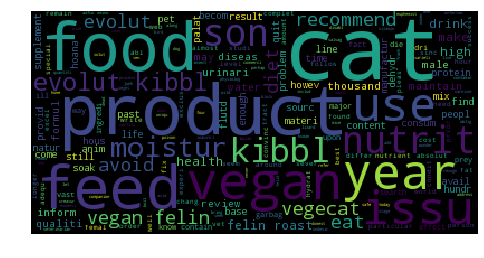





Printing all reviews from cluster 3
3    Unfortunately most people are ill informed about vegan cats, including most veterinarians.<br /><br />Wild cats are in fact obligate carnivores. However, in domesticating the house cat and bringing it into our homes we have effectively removed the cat from its natural prey of mice, insects, birds, lizards, and other small creatures. During the past 100 years or so, as the human food industry was searching for a way to salvage and use all the waste materials from its processing lines, it came upon a wonderful solution. Lets boil it all up and dry it out and add it to the food we make for cats and dogs. As a result, the vast majority of commercial pet foods contain what are euphemistically referred to as the four D's, dead, dying, disabled, and diseased animals, along with other quite undesirable materials. Quite frankly, if you are feeding this junk to your pets, you are effectively poisoning them. We are seeing diseases in pets today that we

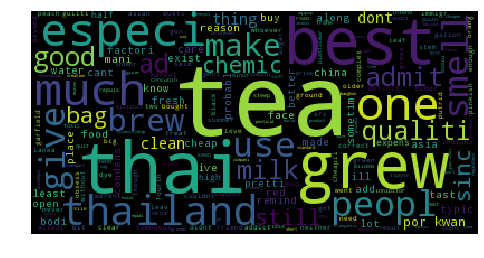





Printing all reviews from cluster 4
4    So I grew up in a townhouse complex with my two best friends being Thai and Indian 1st gen immigrants... I grew up with about a fourth of my food being from their homes--we went to whoever was making the best food. Thai tea was a bit of a guilty obsession for us, especially in the summer. As I got older, the addiction grew, and I've brewed hundreds of gallons of it. That said, I bought this along with the Por Kwan when I couldn't get to my Asian market. The Por Kwan was much better, but neither was especially great; this one is GREEN tea, which Thai tea is NEVER supposed to be. The leaf quality is pretty awful--really dusty, the stems are ground in with the leaves (big no no, clearly cheaply made), and it's DEFINITELY been treated beyond the red dye--which our tea FROM Thailand and Sri Lanka actually didn't need, though admittedly, they weren't garfield orange, more like a pinkish peach, when the milk was added (when it's brewed correctly, G

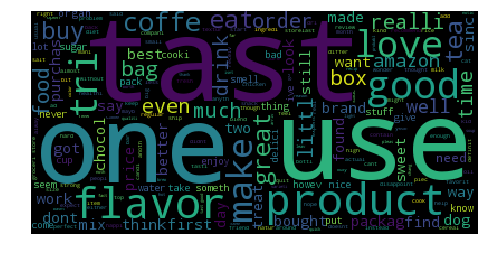





Printing 4 random reviews from cluster 0
0    This mix was given to me originally by someone from Cincinnati. But in the East Coast city where I live, can't find it anywhere. Good mixture of spices, keeps for years, a nice recipe you can make which is a little different but tasty and quick. Always a hit when I make it.                                                                                            
0    This is really quality olive oil for almost the same price if not better than what you'll find in the grocery store.  It has a strong, nutty flavor, reminding us of the freshly pressed oils we've have in Tuscany, Italy.                                                                                                                                                   
0    After having REAL Lichee tea in a California Chinese restaurant, I found that FooJoy Lichee tea is all but flavorless!  I would not recommend it to anyone!                                                   

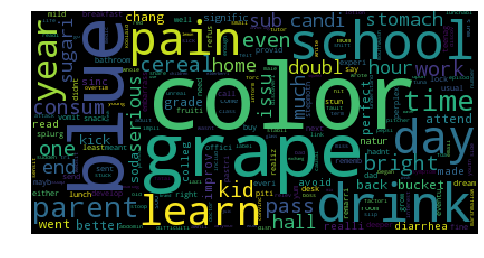





Printing all reviews from cluster 1
1    Over the years my parents would send me to school and I was just fine until usually either lunch or a snack time with the school or a well-meaning room parent providing grape or fruity colored sugary drinks... or bright colorful candies.. or maybe mom splurged on those bright colorful cereals for breakfast. YUM!  Every kids dream, right?<br /><br />Well each  time I consumed some of these brightly colored cereals or pastries or drinks or candies, over the next few hours I would develop at least mild stomach pain. The deeper the color or the more I consumed, the worse the experience. Eventually it ended with me locked in the bathroom, doubled over in pain, for hours on end, as perplexed school officials called my parents to come get me, as I was AGAIN being sent home from school.  I was soo embarrassed. Pity the few subs who refused me a hall pass - I remember vomiting at my desk more than a few times to the stunned sub who hadn't realized ho

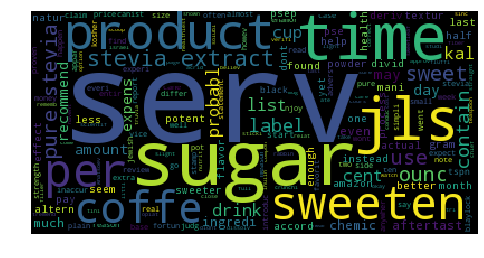





Printing all reviews from cluster 2
2    I started with the 1/2 tspn serving on the label for Just Like Sugar, and went up to about 10 times for sweet coffee.<br /><br />I drink coffee black most of the time, but when I use sweetener I expect it to be sweet with a reasonable amount in accordance with the serving size on the label.  This was not the case with Just Like Sugar (JLS).<br /><br />Based on my experience, which seems to be in accordance with some other reviewers here, instead of "330 servings" as listed on the 5.82 oz container, if you drink only one 6 oz cup of coffee a day, this product will last you anywhere from two weeks to a month and you will get 15-33 servings, if that is all you use it for.  I drink a small pot of coffee (5 cups) a day, so if I sweetened every cup, it would last me 3 - 6 days.  Fortunately I don't drink sweet coffee that often so I won't have to pay an extra $30 a month just for sweetener.<br /><br />Cost:  By Amazon's pricing, <a href="http://ww

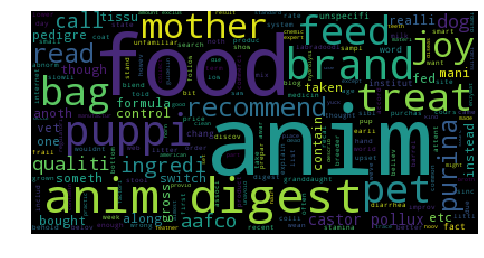





Printing all reviews from cluster 3
3    I recently bought a 7-week-old collie puppy for my granddaughter. Joy, the puppy was taken from her mother at 2 weeks along with 9 siblings because the mother was not producing enough milk. It was the mother's first litter. The pups were hand fed a formula and were a bit small and frail for their ages though their price was not. At any rate the breeder had them on Pedigree puppy food when we purchased her and though their is nothing wrong with the brand I wanted something better for her due to her early weaning. Our 2-year-old Labradoodle is fed "Castor & Pollux" which really improved her coat and stamina etc. when we switched from another brand so I bought Puppy food in the same brand. However our Vet told us that she was unfamiliar with the brand, and that she wouldn't feed it to her. Instead she recommended "Purina One Smart Blend Puppy Formula". I of course ordered a bag and stated mixing it with the Pedigree to switch Joy over slowly so

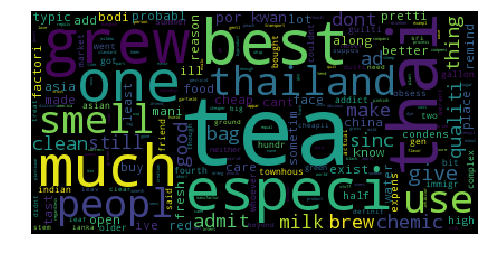





Printing all reviews from cluster 4
4    So I grew up in a townhouse complex with my two best friends being Thai and Indian 1st gen immigrants... I grew up with about a fourth of my food being from their homes--we went to whoever was making the best food. Thai tea was a bit of a guilty obsession for us, especially in the summer. As I got older, the addiction grew, and I've brewed hundreds of gallons of it. That said, I bought this along with the Por Kwan when I couldn't get to my Asian market. The Por Kwan was much better, but neither was especially great; this one is GREEN tea, which Thai tea is NEVER supposed to be. The leaf quality is pretty awful--really dusty, the stems are ground in with the leaves (big no no, clearly cheaply made), and it's DEFINITELY been treated beyond the red dye--which our tea FROM Thailand and Sri Lanka actually didn't need, though admittedly, they weren't garfield orange, more like a pinkish peach, when the milk was added (when it's brewed correctly, G

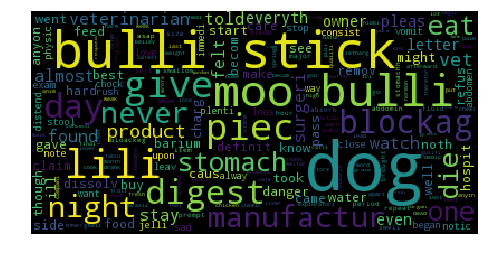





Printing all reviews from cluster 5
5    SADLY, I FOUND OUT THE HARD WAY THAT THESE MOO BULLY STICKS ARE NOT 100% DIGESTIBLE! MY DOG ALMOST DIED AFTER A PIECE DID NOT DISSOLVE IN HER STOMACH.My 3 dogs loved these Moo Bully sticks. I was buying them and giving them because I felt it might causes a chocking danger. I always had plenty of water close by. One day I noticed my dog,Lily, was having very loose stools and that were jelly like in consistency.This same day she stopped eating and began vomiting.I immediately rushed her to my veterinarian.Upon his physical exam he noted that her abdomen was hard and distended.He wanted me to leave her with him so he could do a x-ray. He did and found that she had a bloackege in her stomach!He then started a series of Barium x-rays to watch the blockage to see if it was going to pass. Over a 4 hour period of watching and repeating these barium x-rays it not only showed that the blockage was not passing, but the "item" causing the blockage was s

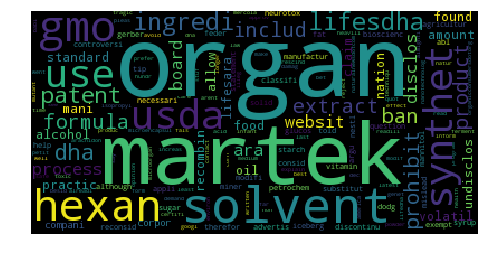





Printing all reviews from cluster 6
6    RECONSIDER THIS FORMULA!!<br /><br />Martek advertises this formula on their website! Nestle owns Gerber now<br /><br />"Although Martek told the board that they would discontinue the use of the controversial neurotoxic solvent n-hexane for DHA/ARA processing, they did not disclose what other synthetic solvents would be substituted. Federal organic standards prohibit the use of all synthetic/petrochemical solvents".<br /><br />Martek Biosciences was able to dodge the ban on hexane-extraction by claiming USDA does not consider omega-3 and omega-6 fats to be "agricultural ingredients." Therefore, they argue, the ban against hexane extraction does not apply. The USDA helped them out by classifying those oils as "necessary vitamins and minerals," which are exempt from the hexane ban. But hexane-extraction is just the tip of the iceberg. Other questionable manufacturing practices and misleading statements by Martek included:<br /><br />Undisclose

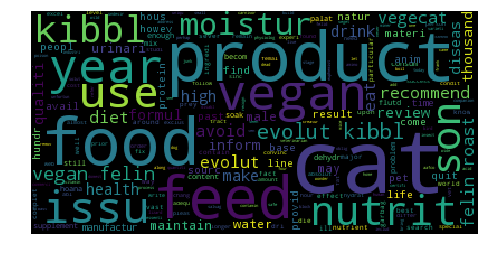





Printing all reviews from cluster 7
7    Unfortunately most people are ill informed about vegan cats, including most veterinarians.<br /><br />Wild cats are in fact obligate carnivores. However, in domesticating the house cat and bringing it into our homes we have effectively removed the cat from its natural prey of mice, insects, birds, lizards, and other small creatures. During the past 100 years or so, as the human food industry was searching for a way to salvage and use all the waste materials from its processing lines, it came upon a wonderful solution. Lets boil it all up and dry it out and add it to the food we make for cats and dogs. As a result, the vast majority of commercial pet foods contain what are euphemistically referred to as the four D's, dead, dying, disabled, and diseased animals, along with other quite undesirable materials. Quite frankly, if you are feeding this junk to your pets, you are effectively poisoning them. We are seeing diseases in pets today that we

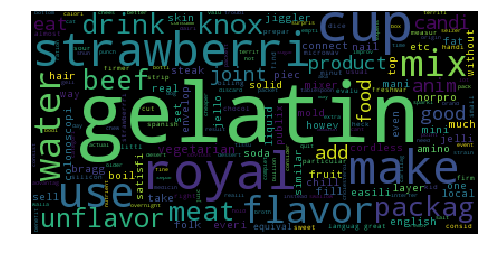





Printing all reviews from cluster 8
8    Royal "Bilingal" Strawberry Gelatin is the same product as Royal ("English Language") Strawberry Gelatin, but in English/Spanish packaging.<br /><br />EVALUATION<br />Good strawberry flavor.  Mixes easily, makes 4 cups.  I like gelatin a little firmer, so I use only 3 cups of water, which I microwave for 5 minutes in a 4-cup measuring cup and then mix-in the Royal Gelatin.  I find a mini-mixer very handy for mixing the gelatin <a href="http://www.amazon.com/gp/product/B000E39LYO">Norpro Cordless Mini Mixer, 5 Piece Set</a><br /><br />ADD FRUIT<br />The strawberrry gelatin is particularly great with real (diced) strawberries which are usually too sour.  The gelatin adds just the right sweetness.<br /><br />JIGGLERS<br />You can make very firm "jigglers" for kids by using only 2 cups of water, or almost "Gummi-Bear" candies by using only 1 one cup of water.  Consider using candy molds  <a href="http://www.amazon.com/gp/product/B003VPW0V8">Fres

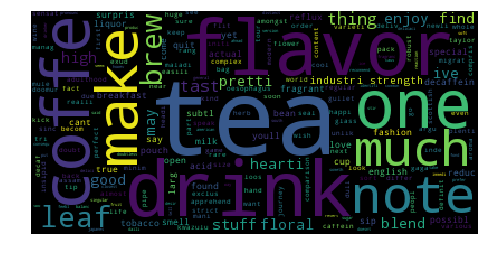





Printing all reviews from cluster 9
9    I've come back to tea after drinking coffee almost exclusively since before adulthood.  A huge part of the migration was, initially, due to that malady of modern life, acid reflux.  Caffeine makes me gullet go gaga.  In fact, I'm even reduced to drinking a blend of decaf and regular tea in order to keep the oesophagus happy.<br />A really cool thing about tea is that, unlike coffee, in its varieties there is a complexity of subtle (and not so subtle) flavors that one can easily apprehend.<br />Sure, there are people who will argue there is a whole range of flavor notes that can be found amongst the various coffee beans and while this is, strictly speaking, true, it is also pretty much true that one cup of good coffee smells and tastes pretty much the same as any other cup of good coffee.  Coffee is not the sort of thing one sips to enjoy as one would a glass of wine.  Drinking tea, on the other hand, can very much become a sipping game possi

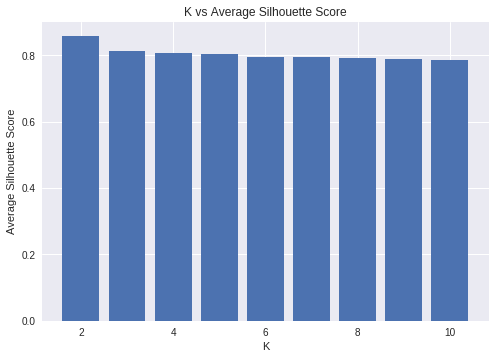

The average Silhouette value of K = 2 is 0.8575178730708878
The average Silhouette value of K = 3 is 0.8125441724821368
The average Silhouette value of K = 4 is 0.8066332736124401
The average Silhouette value of K = 5 is 0.8039834689442472
The average Silhouette value of K = 6 is 0.7944473275548031
The average Silhouette value of K = 7 is 0.794090586742986
The average Silhouette value of K = 8 is 0.7924267009474002
The average Silhouette value of K = 9 is 0.7898085616013221
The average Silhouette value of K = 10 is 0.7865395166877981




We can observe that K = 2 has the highest average silhouette score of 0.8575178730708878.




The wordcloud and reviews for K = 2 is already output above.


In [0]:
agglo_cluster(grouped_data,data)

**Observations: **

**1.** Wordcloud and reviews are printed for k values of 2, 5, 10 to get a sense of what's going on with the data.

**2.** Silhouette scores are plotted for each values of k ranging from 2 to 10. It is observed that k=2 has the highest average silhouette score, hence we declare that k=2 is the best suited number of clusters.

**3.** When k=2, cluster 0 has 4999 elements compared to 1 in cluster 1.

**4.** Cluster 0 reviews mostly revolve the word 'tast', 'use', 'one', 'product'.

**5.** Cluster 1 reviews mostly revolve around the word 'product' and 'cat' which gives us the sense that it is about cat food.

**6.** This featurization produced almost similar results to that of Bag of Words.

# Avg Word2Vec

In [0]:
import pandas as pd
final = pd.read_csv("grouped_data_200.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(3000) #Gets 3000 reviews of positive and 2000 negative scores
neg_2000 = neg.sample(2000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
grouped_data.drop(['Unnamed: 0', 'Unnamed: 0.1','Score'], axis=1, inplace=True)
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (4999, 11)


Observations:
A csv file is imported which consists of 200000 data points. These data points are already sorted on the basis of time. We create a new dataframe with over 5000 data points.

In [0]:
list_of_sent=[]
for sent in grouped_data['CleanedText'].values: #Splits sentences into words and stores it in a list
    list_of_sent.append(sent.split())
print(grouped_data['CleanedText'].values[9])
print("*****************************************************************")
print(list_of_sent[9])

smoke bomb spring load spike trap gave mole invas call extermin use trap didnt miss caught six two day found trap order two month later saw anoth mole tunnel next day care set trap power way extermin get mole
*****************************************************************
['smoke', 'bomb', 'spring', 'load', 'spike', 'trap', 'gave', 'mole', 'invas', 'call', 'extermin', 'use', 'trap', 'didnt', 'miss', 'caught', 'six', 'two', 'day', 'found', 'trap', 'order', 'two', 'month', 'later', 'saw', 'anoth', 'mole', 'tunnel', 'next', 'day', 'care', 'set', 'trap', 'power', 'way', 'extermin', 'get', 'mole']


Observations: It lists out all the words in the review.

In [0]:
w2v_train=Word2Vec(list_of_sent,min_count=5,size=200, workers=4) #Initialises the Word2Vec model with words occuring more than 5 times.

w2v_train_words = list(w2v_train.wv.vocab) #This gives a dictionary of words which tells about the uniqueness of a word among other things.
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[298:315])

number of words that occured minimum 5 times  3308
sample words  ['left', 'can', 'choic', 'local', 'greek', 'paid', 'took', 'five', 'arriv', 'fork', 'sign', 'ever', 'attach', 'seller', 'fail', 'cool', 'address']


Observations: Word2Vec model is initialized with a size 200.

In [0]:
sent_vectors = [];
sent_list = []
for sent in grouped_data['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # For a sentence in the previously created list of sentences
    sent_vec = np.zeros(200) # As word vectors are of zero length, returns an array of size 50 filled with zeros
    i = 0; # Number of words with a valid vector in the sentence/review
    for word in sent: # For each word in a review/sentence
        if word in w2v_train_words:
            vec = w2v_train.wv[word] #Gets the corresponding vector for the word
            sent_vec += vec
            i += 1
    if i != 0:
        sent_vec /= i
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

4999
200


Observations: Vectorizations for the data is obtained of the size mentioned above.

In [0]:
data = StandardScaler(with_mean=False).fit_transform(sent_vectors)

Observations: Data is standardized.





========== When number of clusters is 2 ==========




Creating a dataframe with Reviews, Cleaned text and Clusters...
Dataframe is created!


The number of reviews in each cluster is:
0    3480
1    1519
Name: Clusters, dtype: int64


**********************************************************************




**************************************** Cluster  0 ****************************************


Plot of Word Cloud


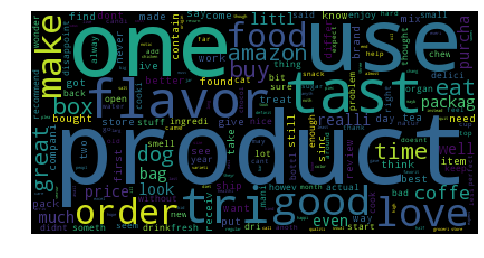





Printing 4 random reviews from cluster 0
0    My baby was on this from 0-9  months as she was a premie. She did very well on it. It has 22 cals per ounce as opposed to 20 cals per ounce like the other formulae. It is a bit more expensive but was worth it.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

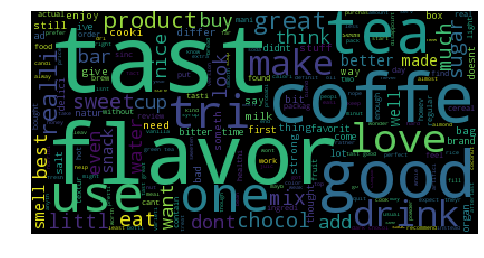





Printing 4 random reviews from cluster 1
1    I usually don't crave sweets but when I do I grab a stick or two and it satisfies my craving.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

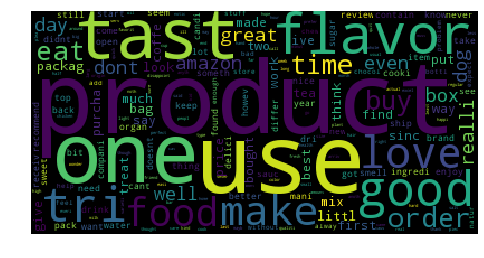





Printing 4 random reviews from cluster 0
0    My family can recall enjoying these cheese treats for over 4 decades.<br />We always had them in the summer on picnics and in the fall in<br />our lunch boxes the first week of school.<br /> Tiger had stopped production for a while, so VERY happy they<br />are available again, wish local stores would carry !<br /> Do not spend your money on The Laughing Cow brand, just try these !                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

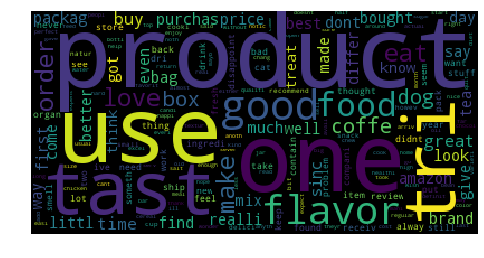





Printing 4 random reviews from cluster 1
1    I could not get the quick barley at Albertson's so turned to the internet.<br />Although 12 boxes is a lot of barley, I was able to sell some of them to friends for cost at $3.17 each, which includes the S & H. Also a local grocer dealing in organic foods took a couple of them.<br />Putting barley in any soup home made or canned adds a flavor I really like, so in two weeks I have used up one 11 ounce box already. It only takes 10 minutes heating the soup with the barley to cook it, either in the microwave or on the stove.<br />Just thinking about it makes my mouth water, mmmmmmmmm.<br />R
1    I had Turtle Island tortilla soup before, it was very good but I can't find that in the local markets, that's why I checked into Amazon and looked for it. Instead I came across the comida loca soup mix reviews, people seem really like it, so I ordered some and tried it out myself. I really enjoy the soup, it is very tasty and easy to make. I won't

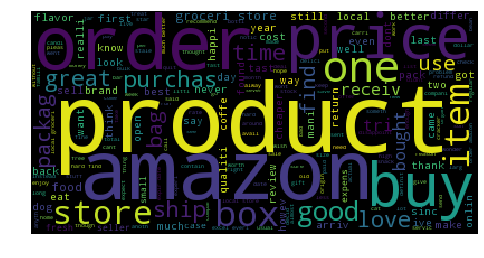





Printing 4 random reviews from cluster 2
2    Product came fast, product came as stated.  No issues.  Would work with seller again.                                                                                                                                                                                                                                                                                                         
2    If you live in the continental US, you can by most (all?) of Rockstar's 16oz cans, in 24-can packs, for $48 WITH FREE SHIPPING.                                                                                                                                                                                                                                                               
2    I ordered this product because I love the "Cheez-It" brand.  I tried this particular item after initial purchase at a grocery store.  I received my item in a timely manner, h

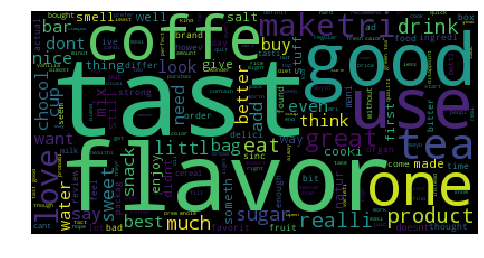





Printing 4 random reviews from cluster 3
3    This coffee tastes really good, and the pods are very convenient to use.  Brewing is fast and cleanup is a snap.  I highly recommend them.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

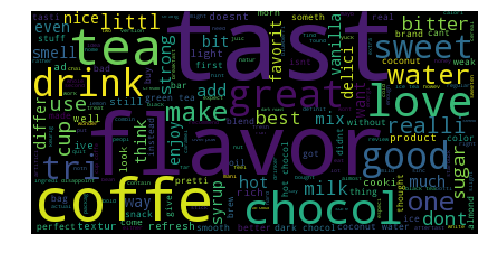





Printing 4 random reviews from cluster 4
4    I use 1/4 cup of wheat gluten per loaf and the bread comes out lovingly spongy just like storebought, but with that homemade taste, mmmmmhh :)                                                                                                                                                                                                                                                                                                                                                                                                         
4    If you're looking for a powdered version of young coconut water this isn't it. This tastes nothing like the tetra packed coconut water and it tastes nothing like fresh young coconut and also has a weird after taste (probably because of the dextrose). Absolutely disappointed.                                                                                                                                      

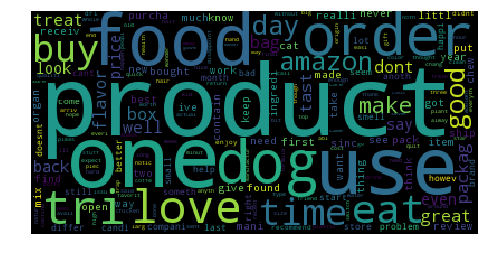





Printing 4 random reviews from cluster 0
0    for caryying this item at a reasonable price.  I really enjoy them, and cannot find them anywhere else.  The scheduling feature for automatic shipments is nice, too.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
0    As someone milk allergic it's insanely difficult to find ramen that has no milk-based ingredients and that is not made on equipment shared with dairy. Tradition's products are not made to cater to the allergic but being Kosher parve means they're suitable. Since they're parve they should also be fine f

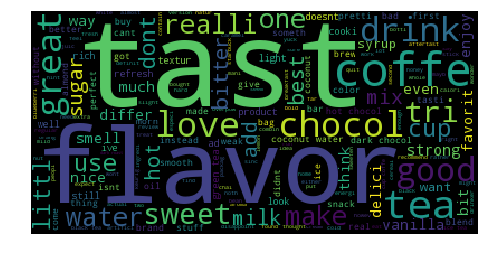





Printing 4 random reviews from cluster 1
1    I use 1/4 cup of wheat gluten per loaf and the bread comes out lovingly spongy just like storebought, but with that homemade taste, mmmmmhh :)                                                                                                                                                                                                                                                                                                                                                                                                         
1    If you're looking for a powdered version of young coconut water this isn't it. This tastes nothing like the tetra packed coconut water and it tastes nothing like fresh young coconut and also has a weird after taste (probably because of the dextrose). Absolutely disappointed.                                                                                                                                      

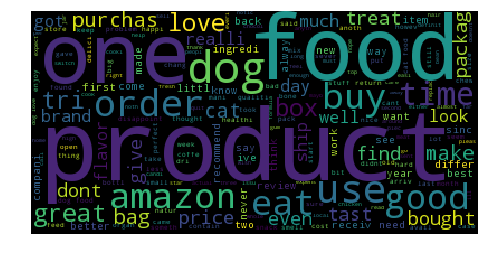





Printing 4 random reviews from cluster 2
2    Took a chance, saw good reviews, bought one box of Angel Hair pasta.  Got it today.  Made regular ole spaghetti and had an awesome tasting meal.  Being on a low carb diet - pasta is a no-no but thankfully Dreamfields has the solution.  Shipping was a bit high for one box so I plan on stocking up on other noodles (lasagna!!) so shipping will be lower.                                                                                                                                                                                                                                                                                  
2    It has been up for 3 days now and the yellow jackets just fly past and don't even give it a nod!                                                                                                                                                                                                                              

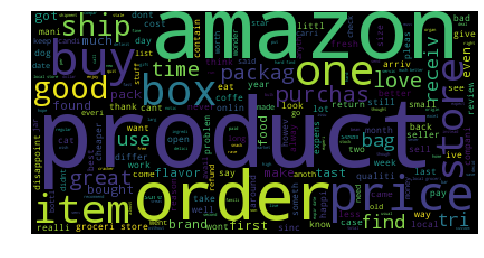





Printing 4 random reviews from cluster 3
3    Like the previous reviewer, I purchased these at Costco.  Their in store price is about half of the Amazon seller's price.  But-Costco doesn't sell these online.  So if Costco is not an alternative, this may be a good option.<br /><br />Package doesn't state country of origin.  Distributed by a Missouri company.  Seal of Veterinary approval on package.  Good ingredients.                                          
3    The pretzels are tasty and convenient, but I can't give them a higher rating due to the extreme jump in price (nearly double the price it was a couple of weeks ago when I made the purchase-around $17). Due to this, I assume the previous great reviews are based on the former price. Now I can pick these up at my local Grocery for close to the same price per bag, which defeats the purchase of buying in bulk online.
3    While I love the taste of Green Mountain Hot Cocoa, the prices for these k-cups on Amazon are outrageous. I 

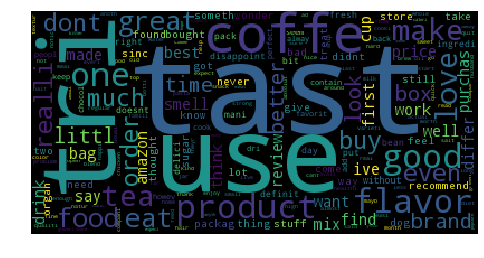





Printing 4 random reviews from cluster 4
4    We used to eat this all the time when I was growing up, but sadly they have taken it off the market in my area.  I love the tangy sauce it makes with its herbs and spices mixture.  It is inexpensive, and makes enough to feed a family of 4.  It is also low calorie..you get a cup of prepared spaghetti for only 240 calories!  I am so glad I found this Kraft mix on Amazon.com.  Delicious!!!                                                                                                                                                                                                                      
4    My review is for the product cookie itself, not what might happen if you buy food from Amazon. Oreo is a classic cookie, and while I can't say that I am a big fan of all their flavors, I really enjoy three flavors - original, Uh-Oh Oreos, and the top of the list, Mint Oreos. The flavor is strongly reminiscent of the Thin Mint cookies sold 

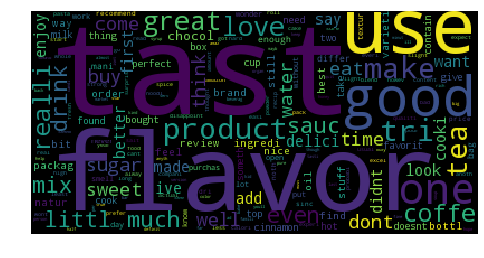





Printing 4 random reviews from cluster 5
5    I'm a professionally trained pastry chef, and I have to say I was blown away at the high quality of the product. I'm usually averse to using mixes, but the Cherrybrook Kitchen products do a great job at balancing exceptional flavor with non-dairy ingredients.<br /><br />I've baked out the chocolate cake, yellow cake and brownie mixes several times and they always come out as expected. The frosting mixes are also exceptional and offer room for modulating the ingredients if you prefer to use butter/margarine blends for richness - not vegan, I know, but the flavor isn't lost either way.<br /><br />The sugar content is low, which helps to keep the calorie count down on these cakes - for those dieting, or watching their sugar intake. Overall, I highly recommend these cake and frosting mixes.<br /><br />A note about baking:  home ovens vary in temperature for a variety of reasons. If you suspect that your oven temps are not what they should b

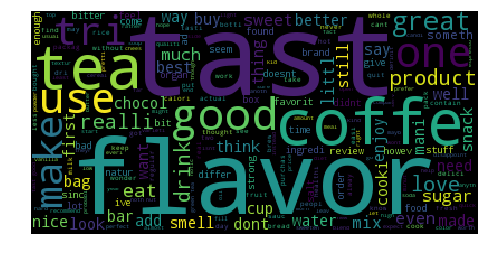





Printing 4 random reviews from cluster 6
6    Was really looking forward to trying this tea and expected to love it. I brewed it and was unsure as to the aroma and strong coloration. Sipped it once and never went back for more. My husband did the same thing. The taste is terrible. Threw the whole thing out. Yuck!                                                                                                                                                                   
6    Much too salty, despite the claim otherwise.  It says on the package, "When it is salty enough, it's seasoned to perfection."  For me, if it's "seasoned to perfection", the salt is absolutely choking.  If I sprinkle it with the right amount of salt, I can't taste the seasoning flavors.<br /><br />If this is supposed to be lower in salt, just imagine what the regular stuff will be!<br /><br />I won't be buying this again.       
6    This is my favorite oat bran, and I've tried many many brands. I like that t

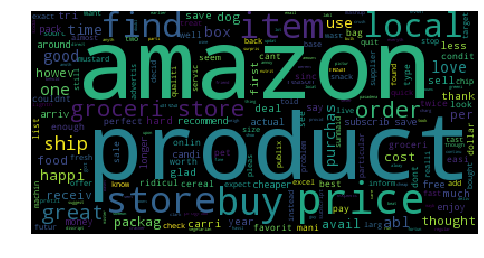





Printing 4 random reviews from cluster 7
7    I don't believe they are selling these for so much, in Seattle we can get them<br />for $1.50 per 16oz. package at the local asian grocery store.                                                                                                
7    This item was ordered as a package deal (saved $1!!!). One was sized for a 150 lb. Great Dane, one for a 5 lb. dog and this one is just right but impossible for me to get food into or a dog (or me) to get it out. Recommended by local SPCA!!!
7    I used to have a Subscribe and Save subscription to this item when it was ~9 a can, now it's ridiculously more expensive (~18 a can) than my local grocery store prices.  Wait for a sale at Safeway and then buy 3 or 4.                        
7    The product arrived as told.  The dogs enjoyed the chews.  Fort the price, it was worth it. I would reccomend this product.                                                                                      

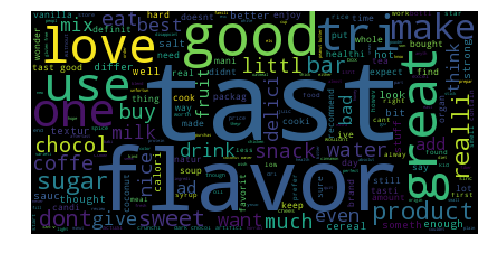





Printing 4 random reviews from cluster 8
8    Please save your money. Didn't care for the color, which I could have over looked if the product was good, but this is just bad and nasty tasting. And not like real water at all.  I'll stick with plain old tap water.                                                                   
8    I got this sauce thinking it would be something good! Wrong!!  This sauce has no flavor, to me it is like thinned out mayo!  I cannot taste any spice in the sauce.  I wouldn't even rate this as mild, it is just colored mayo!  Did not like, did not taste good, and will not buy again!
8    I've had coconut water and this is just plain nasty! Plus it's mixed with other fruits and instead of tasting good it taste horrible. I know the name and label are appealing. I don't recommend this product to anyone not even my mother-in-law.                                         
8    With some heated non-fat milk, it's one of the best ways to treat myself.I love the

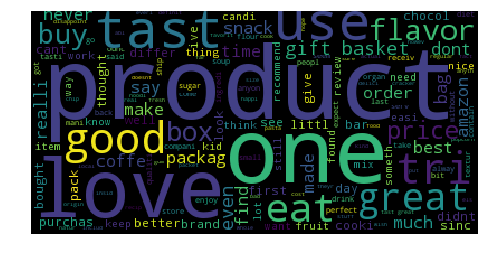





Printing 4 random reviews from cluster 9
9    This is a great soup base, and I think it's a better used as a base than stand-alone as a finished product. Consider making a soup with shrimp, fish balls, vegetables, and then serving it over noodles. A fair price would be $3.00 per bottle, however.                                                                                                                                                                                                                                           
9    I baught this kind of cereal from Wholefood. Since this was the first time I tried this brand, I picked 3 kinds: multi-grain, oatmeal and brown rice. Oatmeal was all right, but the other two smelled like they were already stale(the expiration day is May 2013), and they tasted bad too and sticked on my throat when I tried them. My baby cried and refused to eat them. The customer service of Wholefood was very nice and refunded me. I don't think I will buy t

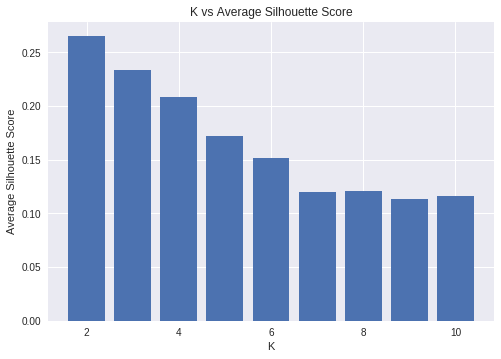

The average Silhouette value of K = 2 is 0.265083471412089
The average Silhouette value of K = 3 is 0.2335033061836744
The average Silhouette value of K = 4 is 0.2079240138105294
The average Silhouette value of K = 5 is 0.17202005238657234
The average Silhouette value of K = 6 is 0.15112498897480978
The average Silhouette value of K = 7 is 0.11963347002040632
The average Silhouette value of K = 8 is 0.12057144149604214
The average Silhouette value of K = 9 is 0.11301937111529721
The average Silhouette value of K = 10 is 0.11660902343156512




We can observe that K = 2 has the highest average silhouette score of 0.265083471412089.




The wordcloud and reviews for K = 2 is already output above.


In [0]:
agglo_cluster(grouped_data,data)

**Observations: **

**1.** Wordcloud and reviews are printed for k values of 2, 5, 10 to get a sense of what's going on  with the data.

**2.** Silhouette scores are plotted for each values of k ranging from 2 to 10. It is observed that k=2 has the highest average silhouette score, hence we declare that k=2 is the best suited number of clusters.

**3.** Since the average value of all the silhouette scores is around 0.16, k values of 3, 4, 5 can also perform reasonably well.

**4.** When k=2, cluster 0 has 3480 elements compared to 1519 in cluster 1.

**5.** Cluster 0 reviews mostly revolve around the words 'flavor', 'use', 'tast', 'product'. The customers usualy talked about the flavour of the product, how did it taste and its uses. Majority of them seem to like it due to the occurance of the words 'love' and 'good'.

**6.** Cluster 1 reviews mostly revolve around the words 'tast', 'flavor' and 'coffe' which gives us the sense that it is about products related to beverages like coffee and tea. It also says that the customers usually talked about the product and its flavour and majority of them liked it because of the words 'love' and 'good' appearing frequently.

# TFIDF Word2Vec

In [0]:
import pandas as pd
final = pd.read_csv("drive/Colab Notebooks/grouped_data_200.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(3000) #Gets 3000 reviews of positive and 2000 negative scores
neg_2000 = neg.sample(2000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
grouped_data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores=grouped_data['Score']
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (4999, 12)


Observations:
A csv file is imported which consists of 200000 data points. These data points are already sorted on the basis of time. We create a new dataframe with over 5000 data points.

In [0]:
list_of_sent=[]
for sent in grouped_data['CleanedText'].values: #Splits sentences into words and stores it in a list
    list_of_sent.append(sent.split())
print(grouped_data['CleanedText'].values[9])
print("*****************************************************************")
print(list_of_sent[9])

letter nice simpl gummi flavor come varieti fruit flavor like lemon fruit punch despit product descript say soft fact would character consist pretti tough requir consum jaw exercis person like littl chew may pleas tough also let gummi hold alphabet shape well
*****************************************************************
['letter', 'nice', 'simpl', 'gummi', 'flavor', 'come', 'varieti', 'fruit', 'flavor', 'like', 'lemon', 'fruit', 'punch', 'despit', 'product', 'descript', 'say', 'soft', 'fact', 'would', 'character', 'consist', 'pretti', 'tough', 'requir', 'consum', 'jaw', 'exercis', 'person', 'like', 'littl', 'chew', 'may', 'pleas', 'tough', 'also', 'let', 'gummi', 'hold', 'alphabet', 'shape', 'well']


Observations: It lists out all the words in the review.

In [0]:
w2v_train=Word2Vec(list_of_sent,min_count=5,size=200, workers=4) #Initialises the Word2Vec model with words occuring more than 5 times.

w2v_train_words = list(w2v_train.wv.vocab) #This gives a dictionary of words which tells about the uniqueness of a word among other things.
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[298:315])

number of words that occured minimum 5 times  3347
sample words  ['soft', 'fact', 'consist', 'tough', 'requir', 'consum', 'jaw', 'exercis', 'chew', 'may', 'pleas', 'also', 'hold', 'well', 'realiz', 'bad', 'ginger']


Observations: Word2Vec model is initialized with a size 200.

Observations:
Word2Vec model is built. We can see the number of times a word occured minimum 5 times.

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab_tf_idf = tf_idf_vect.fit_transform(grouped_data['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names()
dictionary = dict(zip(tfidf_feat, list(tf_idf_vect.idf_)))

Observations:
We build the vocabulary of TF-IDF on the whole data and transform it.

In [0]:
sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
sent_list = []
for sent in grouped_data['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # for each review/sentence 
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_train_words:
            try:
                vec = w2v_train.wv[word] # obtain the tf_idfidf of a word in a sentence/review
                tf_idf  = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors.append(sent_vec)
    row += 1
print(len(sent_vectors))
print(len(sent_vectors[0]))

4999
200


Observations: Vectorization is performed on the whole data.

In [0]:
data = StandardScaler(with_mean=False).fit_transform(sent_vectors)

Observations: Standardization is performed.





========== When number of clusters is 2 ==========




Creating a dataframe with Reviews, Cleaned text and Clusters...
Dataframe is created!


The number of reviews in each cluster is:
0    3480
1    1519
Name: Clusters, dtype: int64


**********************************************************************




**************************************** Cluster  0 ****************************************


Plot of Word Cloud


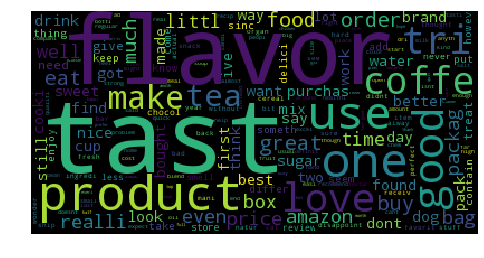





Printing 4 random reviews from cluster 0
0    These are absolutely my favorite brownies. I enjoy a rich chocolate taste, so if you prefer a watered down milk chocolate effect, keep on looking. It is important to not overbake them so that they are still fudgy in the middle. They taste better than any other mix I have ever tried.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

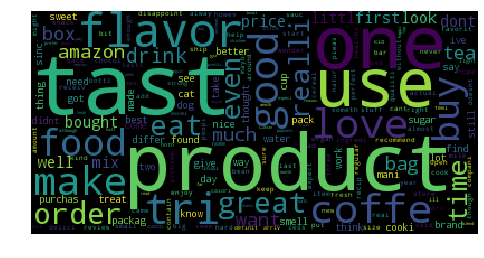





Printing 4 random reviews from cluster 1
1    awsom fun candy you wont regret buying it you will regrete if you dont buy enough                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
1    I originaly was purchasing one bag of the Plato chicken treats from another web site until I found this g

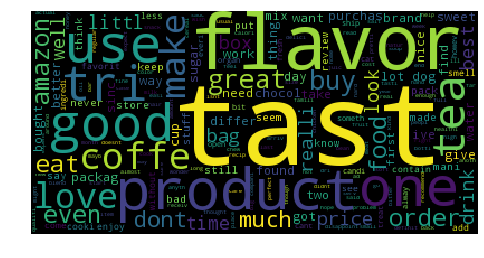





Printing 4 random reviews from cluster 0
0    As with the other reviewer, this is the only formula our baby can handle also.  This product, for us, is perfect for taking with us in the car.  No need to use one of those lousy car charger bottle warmers.  However... unless your baby is eating a full 8 ounces, you'll have left-overs that you'll either need to store in a bottle and keep cool, or throw it out.<br /><br />This fomula, in and of itself, has been wonderful.  While it didn't eliminate our baby's colic, it did reduce it.  In addition, other formulas caused him to have major difficulty with bowel movements.  This formula had a significant impact on that as well.  It does, however, cause him to be seriously gassy. LOL<br /><br />We have noticed that our local Toys R' Us carries this product also.  However, with Amazon Prime covering the shipping, it is just as cheap to get it through this site and save a trip to that parental Hades of a store.
0    Hopefully they got a new shi

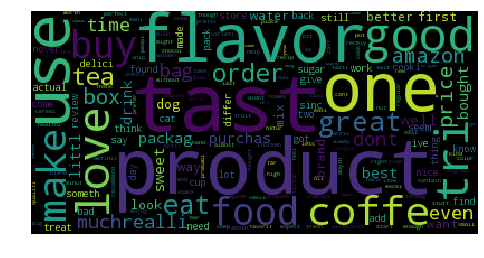





Printing 4 random reviews from cluster 1
1    I bought these for an after school snack for my kiddos, but after I tried them and realized they were so tasty, I kept stealing them for myself.                                                                                                                                             
1    Coffees are ok, but 9 of the k-cups were tea. What a waste. I thought this was a coffee sampler pack. Won't buy again. Try Coffee People coffees instead...delicious!                                                                                                                        
1    Of the vatious brands of Turkish Delight we've tried, this one is, by far, the worst one.  Its texture is grainy, and the taste is medicinal, with the mint version being the most offensive.  We have nearly the 4-box order left, and will end up throwing it all away.  Buy another brand.
1    This coffee tastes really good, and the pods are very convenient to use.  Bre

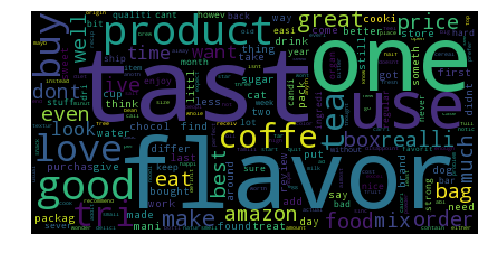





Printing 4 random reviews from cluster 2
2    The description says it contains "no stabilizers", yet the case I received on 2/24/10 contains guar gum and stabilizers. The ingredients list reads: "Coconut extract, guar gum, emulsifier, stabilizer".<br /><br />I am very unhappy about this - the ONLY reason I ordered it was because it was advertised as not having any stabilizers.                                                                                                                                                                                                                                                                                                                
2    My dog will do just about anything for this treat. Also, each treat can be cut easily into for small pieces for training. Ingredients listed are good quality. I had no ill effects from giving to my dog. Beef was the flavor I purchased this time                                                               

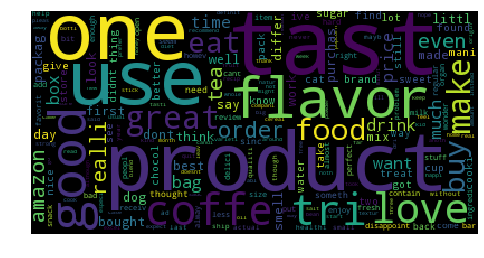





Printing 4 random reviews from cluster 3
3    This is definitely the best ginger candy outside of eating crystallized ginger root. It is not too sweet or too hard and packed with ginger, which is yummy all the time but especially good for nausea. I am buying more for my pregnant friend to get her through her first trimester.                                                                                                                             
3    This didn't last more than a couple of days.  My 30 lb. Brittany destroyed it.  I got a Kong to replace it and it's MUCH sturdier!                                                                                                                                                                                                                                                                                   
3    I am very thankful that you carry Kellogg's Product 19 as I would not know where else to buy it as very few stores carry it now.

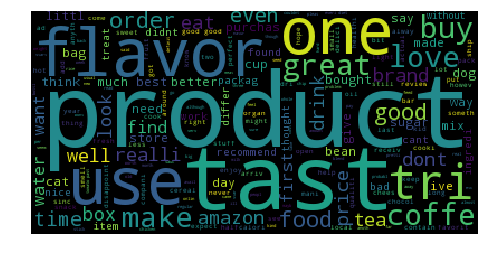





Printing 4 random reviews from cluster 4
4    Tried to purchase this item early in December. Was told it would ship in a few days.  Two weeks later, still nothing.  Tried contacting the vendor (by both email and telephone), and they never responded.  This was meant to be a Christmas present for someone and I needed to scramble to buy something else.  Clearly I don't recommend you buying from this vendor.                                                                                                                                                                                                                                                      
4    I was going out of town for X-Mas and thought these would keep my boys a bit entertained while I was gone.  I have two smallish (15 pound) Boston Terriers and they each completely destroyed one of these in about five minutes.<br />The ball works OK for a fetch toy, but aside from that, these really sucks.                               

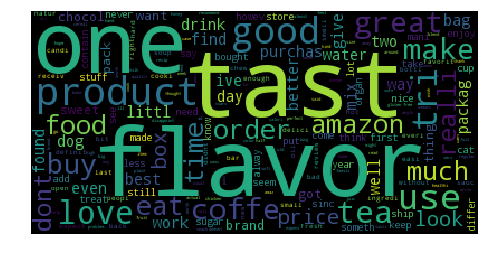





Printing 4 random reviews from cluster 0
0    I bought the 1 lb. bag for something like a trial-pack, and I regret not buying more! This was the first time I had ever used oat bran, so I was not quite sure what to do with it, but I have found that it works EXTREMELY well when mixed with old-fashioned oats (for my typical breakfast of pumpkin maple oatmeal =]) The oat bran is finely ground, but it does a great job thickening up oats and giving it more texture as well as a little additional fiber. I highly recommend this product, and I look forward to purchasing more from Barry Farm
0    I had heard so many good things about Illy coffee, that I thought I would fork over the [...] and give it a shot. When opening the can, I expected to see beautiful whole beans with a rich oily glaze. But, instead I saw small broken beans that were very dry. So I brewed a pot in hopes that it would still be good. But the fact is, it is pretty bitter with a charcoal aftertaste. Don't get me wrong...it'

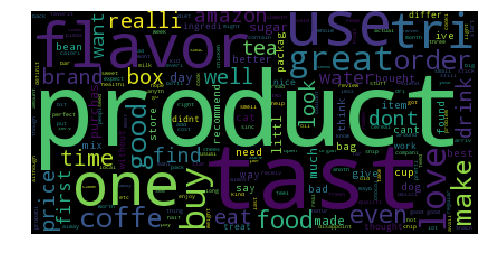





Printing 4 random reviews from cluster 1
1    Tried to purchase this item early in December. Was told it would ship in a few days.  Two weeks later, still nothing.  Tried contacting the vendor (by both email and telephone), and they never responded.  This was meant to be a Christmas present for someone and I needed to scramble to buy something else.  Clearly I don't recommend you buying from this vendor.                                                                                                                                                                                                                                                      
1    I was going out of town for X-Mas and thought these would keep my boys a bit entertained while I was gone.  I have two smallish (15 pound) Boston Terriers and they each completely destroyed one of these in about five minutes.<br />The ball works OK for a fetch toy, but aside from that, these really sucks.                               

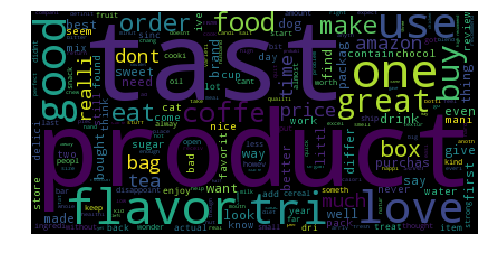





Printing 4 random reviews from cluster 2
2    If you are a Celiac, or are gluten intolerant, you won't find a better pretzel than the Glutino brand.  I have them on Auto-Delivery with Amazon.                                                                                                                                                                                                                                                          
2    Our middle school students were delighted when they received Zotz at school.  Zotz are fun and tradeable.                                                                                                                                                                                                                                                                                                  
2    If you like all flavors of jelly beans and then some, these are for you.  Great by the handful!                                                     

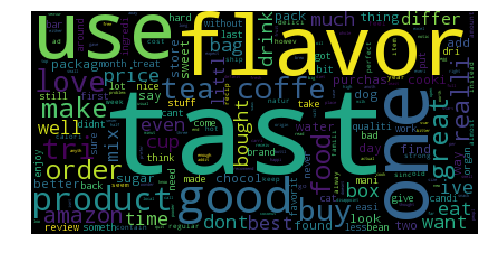





Printing 4 random reviews from cluster 3
3    I mix it in smoothies and ice cream and have it every morning. In ice cream, I can't taste it at all. It does need some masking, not the best flavor, but grape juice and bananas work well, berries too. Feel very regular since I started using it. The price was great and it will last a long time, since I've followed the freezing/refrigeration instructions. I figure I can't go wrong with this fiber and protein source. It encourages me to eat more fruit, and I'm starting to blend in a few veggies too and you can't get enough of those! I even found recipes online for baking with this stuff and made oatmeal cookies that actually turned out good! I recommend it to anyone who wants more fiber in their diet and likes experimenting with new recipes for baking and blending drinks.                                                                                                                                                                          

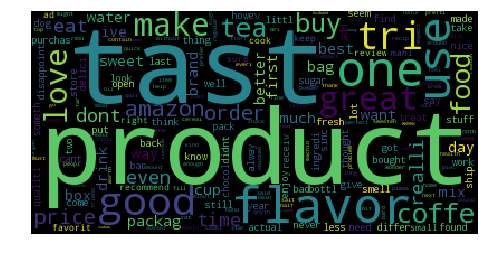





Printing 4 random reviews from cluster 4
4    Mixes well in a blender and no powdery taste noted. NOthing special but nothing bad either.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

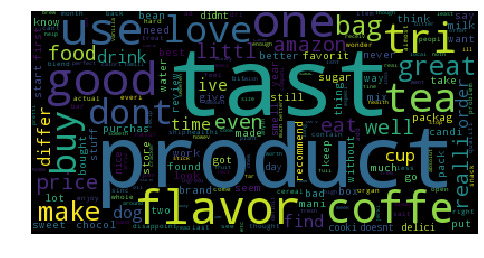





Printing 4 random reviews from cluster 5
5    I can't recommend this flavor for now because at least one out of five cups had a problem that resulted in grounds in my coffee. I've used this in two machines, one is less than a month old - same outcome. Maybe it's just a bad batch, I'd like to know if other reviewers are having similar problems. I've always bought Timothy's and hope that this is just an anomaly. Two out of five stars because the majority of brews made came out fine. Will update this review if I feel I can recommend this flavor again.
5    We discovered Borders Dark Chocolate Gingers on a trip to England and brought a box home with us that disappeared all too quickly. Why, oh why hadn't we brought more home? So I went online and googled and to my delight found I could order them through Amazon! They have that wonderful ginger "bite" enrobed in delicious dark chocolate and are positively addictive. Try them! If you like ginger, you'll love these.                       

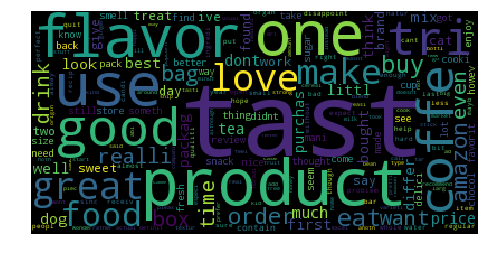





Printing 4 random reviews from cluster 6
6    The quality of the coffee was good (we like Starbucks and stronger coffee) - tasted fresh (which it should be in the fancy box packaging and vacuum sealed aluminum bag).<br /><br />That said, pay attention to your price per ounce. At Starbucks, you pay about $10 for a 1 pound (16 ounce) bag. At the grocery store, you normally pay about $7 for a 12 ounce bag.<br /><br />Here, you are only getting 8 ounce bags!! So, do your math to see if it is worth the money for you.                                                         
6    I wanted so much to like this product!  I had heard wonderful things about the tea (as you can see by the glowing reviews)  but I could not tolerate the smell.  I opened the bag and thought it smelled exactly like pipe tobacco.  In spite of this, I forced myself to brew some.  It was horrible!  Saying this has an "unusual flavor" is downplaying the nauseating taste.  I was seriously ill afterwards.  If anyone kno

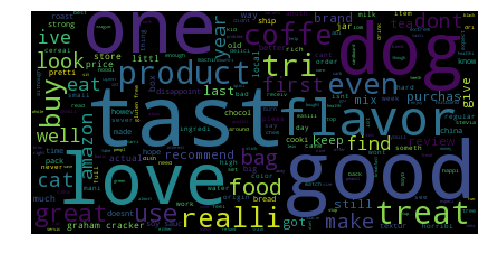





Printing 4 random reviews from cluster 7
7    My family and I are relatively new to gluten free and we have been in search of a baking mix to replace our weekend breakfasts.  We have tried several others and they all taste "gluten free", if you know what I mean.  Pamela's however, is so good and you can't tell its gluten free. Try it, you won't regret it!                                                                                                                                                                                   
7    Just got my coffee, I will use it as an emergency supply, when my every day coffee (from local roaster) runs out.<br />I tasted it this morning, very disappointed. I taste like cardboard/old/vented coffee... I expected much better from Lavazza.<br />Maybe the lot I got is a old one... Who know, won't buy it again.                                                                                                                                           

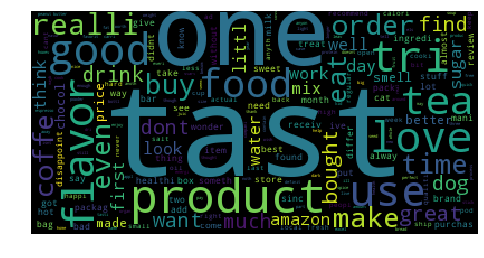





Printing 4 random reviews from cluster 8
8    Since I had been recuperating from a 24 hour flu bug that lasted a<br />week, I knew I was low on electrolytes.  I opted for this product,<br />as some products tend to further aggravate my stomach and<br />acid reflux.  This worked out extremely well, and the taste<br />is good.  I WILL keep it on hand from now on!                                                                                                                                                                                                                                                                                            
8    I'm wondering whether they forgot to put the peppermint oil in this batch. It's just soft, sugar candy with the faintest hint of peppermint. I've used Bob's peppermint sticks for several years for my favorite peppermint pie and never been disappointed before.<br /><br />Well, I made the pie according to Paula Deen's recipe, but after mixing 

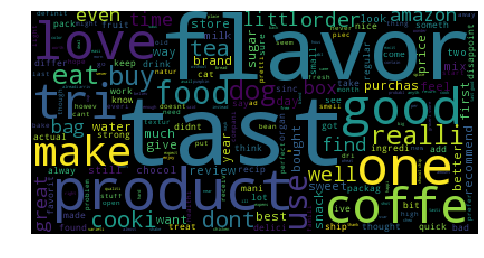





Printing 4 random reviews from cluster 9
9    Purchased this in a small bag just to try and dogs loved it as they do all of the natural balance. Stools were firm. Definitly will buy again.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

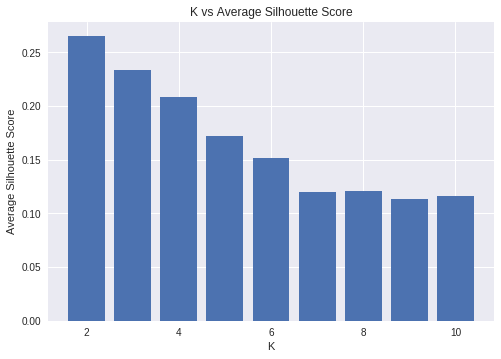

The average Silhouette value of K = 2 is 0.265083471412089
The average Silhouette value of K = 3 is 0.2335033061836744
The average Silhouette value of K = 4 is 0.2079240138105294
The average Silhouette value of K = 5 is 0.17202005238657234
The average Silhouette value of K = 6 is 0.15112498897480978
The average Silhouette value of K = 7 is 0.11963347002040632
The average Silhouette value of K = 8 is 0.12057144149604214
The average Silhouette value of K = 9 is 0.11301937111529721
The average Silhouette value of K = 10 is 0.11660902343156512




We can observe that K = 2 has the highest average silhouette score of 0.265083471412089.




The wordcloud and reviews for K = 2 is already output above.


In [0]:
agglo_cluster(grouped_data,data)

**Observations: **

**1.** Wordcloud and reviews are printed for k values of 2, 5, 10 to get a sense of what's going on  with the data.

**2.** Silhouette scores are plotted for each values of k ranging from 2 to 10. It is observed that k=2 has the highest average silhouette score, hence we declare that k=2 is the best suited number of clusters.

**3.** Since the average value of all the silhouette scores is around 0.16, k values of 3, 4, 5 can also perform reasonably well.

**4.** When k=2, cluster 0 has 3480 elements compared to 1519 in cluster 1.

**5.** Cluster 0 reviews mostly revolve around the words 'flavor', 'use', 'tast', 'product'. The customers usualy talked about the flavour of the product, how did it taste and its uses. Majority of them seem to like it due to the occurance of the words 'love' and 'good'.

**6.** Cluster 1 reviews mostly revolve around the words 'tast', 'product' and 'use'. It also says that the customers usually talked about the product and its flavour and majority of them liked it because of the words 'love' and 'good' appearing frequently.

# Summary and Conclusions

1) Import the csv file containing pre processed data which is already arranged on the basis of time.

2) Two functions are created for plotting wordcloud and for performing agglomerative clustering.

3) The first function creates a dataframe with all the reviews, cleaned text and clusters. Then it prints the number of data points in each cluster. A wordcloud is then plotted along with a few random reviews from that cluster.

4) The second function performs agglomerative clustering and gets the best k value by plotiing the silhouette scores and gets the labels for visualisation through wordcloud.

5) Since this is computationally expensive, we limit the number of data points to 5000.

5) These functions are applied on Bag of Words, TFIDF, avg Word2Vec and TFIDF Word2Vec.

6) It can be observed that almost all vectorizations have the highest average silhouette score for k = 2.